<a href="https://colab.research.google.com/github/Ferdoussazid/ML_SPRING_23_24/blob/main/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
########################################################################
#
# Functions for downloading and extracting data-files from the internet.
#
# Implemented in Python 3.5
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import sys
import os
import urllib.request
import tarfile
import zipfile

########################################################################


def _print_download_progress(count, block_size, total_size):
    """
    Function used for printing the download progress.
    Used as a call-back function in maybe_download_and_extract().
    """

    # Percentage completion.
    pct_complete = float(count * block_size) / total_size

    # Status-message. Note the \r which means the line should overwrite itself.
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


########################################################################


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


########################################################################


In [41]:
import pickle
import numpy as np
import os
import platform


def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte



Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(1000, 3072) (100, 3072)
Got 24 / 100 correct with k=5 => accuracy: 0.240000
Average accuracy with Euclidean distance: 0.238
Average accuracy with Manhattan distance: 0.25
Manhattan distance performs better.
Average accuracy with Euclidean distance: 0.223
Average accuracy with Manhattan distance: 0.244
Manhattan distance performs better.
Average accuracy with Euclidean distance: 0.22433333333333336
Average accuracy with Manhattan distance: 0.24333333333333332
Manhattan distance performs better.
Average accuracy with Euclidean distance: 0.22375
Average accuracy with Manhattan distance: 0.244
Manhattan distance performs better.
Average accuracy with Euclidean distance: 0.22400000000000003
Average accuracy with Manhattan distance: 0.24300000000000002
Manhattan distance performs better.


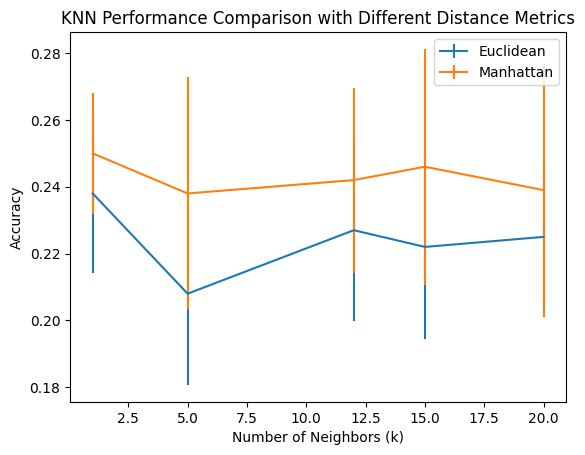

Best k: 1, Best distance metric: manhattan, Test accuracy: 0.3


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

def download_data():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    download_dir = "./data"
    download.maybe_download_and_extract(url,download_dir)

# Class to initialize and apply K-nearest neighbour classifier
class KNearestNeighbor(object):
    def __init__(self):
        pass

    # Method to initialize classifier with training data
    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    # Method to predict labels of test examples using 'compute_distances' and 'predict_labels' methods.
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)

    # Method to compute Euclidean distances from each test example to every training example
    def compute_distances(self, X, distance_metric='euclidean'):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            if distance_metric == 'euclidean':
                # Compute Euclidean distance between test example i and every training example
                dists[i] = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
            elif distance_metric == 'manhattan':
                # Compute Manhattan distance between test example i and every training example
                dists[i] = np.sum(np.abs(self.X_train - X[i]), axis=1)
            else:
                raise ValueError('Invalid distance metric')
        return dists

    # Method to predict labels of test examples using chosen value of k given Euclidean distances obtained from 'compute_distances' method.
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # Find indices of k nearest neighbors for test example i
            closest_y = self.y_train[np.argsort(dists[i])[:k]]
            # Find the most common class label among the k nearest neighbors
            y_pred[i] = np.argmax(np.bincount(closest_y))
        return y_pred

def visualize_data(X_train, y_train):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

def plot_comparison(k_choices, accuracies_mean_euclidean, accuracies_std_euclidean, accuracies_mean_manhattan, accuracies_std_manhattan):
    plt.errorbar(k_choices, accuracies_mean_euclidean, yerr=accuracies_std_euclidean, label='Euclidean')
    plt.errorbar(k_choices, accuracies_mean_manhattan, yerr=accuracies_std_manhattan, label='Manhattan')
    plt.title('KNN Performance Comparison with Different Distance Metrics')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.savefig('cross-validation_accuracy in both distance Metrics.jpg')
    plt.legend()
    plt.show()

if __name__ == "__main__":

    # Download CIFAR10 data and store it in the current directory if you have not done it.
    #download_data()
    cifar10_dir = './data/cifar-10-batches-py'

    # Load training and testing data from CIFAR10 dataset
    X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

    # Checking the size of the training and testing data
    print('Training data shape: ', X_train.shape)
    print('Training labels shape: ', y_train.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    # Visualize the data if you want
    #visualize_data(X_train, y_train)

    # Memory error prevention by subsampling data. We sample 10000 training examples and 1000 test examples.
    num_training = 1000
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    num_test = 100
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Reshape data and place into rows. Flatten the training and test data so each row consists of all pixels of an example
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    print(X_train.shape, X_test.shape) # X_train should be (10000, 3072) and X_test should be (1000, 3072)

    # Performing KNN
    classifier = KNearestNeighbor()
    classifier.train(X_train, y_train)
    y_test_pred = classifier.predict(X_test, k=5)

    num_correct = np.sum(y_test_pred == y_test) # number of test examples correctly predicted, where y_test_pred should contain labels predicted by classifier
    accuracy = float(num_correct) / num_test
    print('Got %d / %d correct with k=5 => accuracy: %f' % (num_correct, num_test, accuracy))
    # Accuracy above should be ~ 29-30%

    # Perform 5-fold cross-validation to find the optimal k from choices below
    num_folds = 5
    k_choices = [1, 5, 12, 15, 20]
    X_train_folds = np.array_split(X_train, num_folds)
    y_train_folds = np.array_split(y_train, num_folds)
    k_to_accuracies_euclidean = {} # dictionary to hold validation accuracies for each k
    k_to_accuracies_manhattan = {} # dictionary to hold validation accuracies for each k

    accuracies_mean_euclidean = []
    accuracies_std_euclidean = []
    accuracies_mean_manhattan = []
    accuracies_std_manhattan = []

    for k in k_choices:
        k_to_accuracies_euclidean[k] = []
        k_to_accuracies_manhattan[k] = []

        for num_knn in range(num_folds):
            X_train_fold = np.concatenate([X_train_fold for i, X_train_fold in enumerate(X_train_folds) if i != num_knn])
            y_train_fold = np.concatenate([y_train_fold for i, y_train_fold in enumerate(y_train_folds) if i != num_knn])
            X_val_fold = X_train_folds[num_knn]
            y_val_fold = y_train_folds[num_knn]

            classifier = KNearestNeighbor()
            classifier.train(X_train_fold, y_train_fold)

            dists_euclidean = classifier.compute_distances(X_val_fold, distance_metric='euclidean')
            dists_manhattan = classifier.compute_distances(X_val_fold, distance_metric='manhattan')

            y_val_pred_euclidean = classifier.predict_labels(dists_euclidean, k=k)
            y_val_pred_manhattan = classifier.predict_labels(dists_manhattan, k=k)

            num_correct_euclidean = np.sum(y_val_pred_euclidean == y_val_fold)
            accuracy_euclidean = float(num_correct_euclidean) / len(y_val_fold)
            k_to_accuracies_euclidean[k].append(accuracy_euclidean)

            num_correct_manhattan = np.sum(y_val_pred_manhattan == y_val_fold)
            accuracy_manhattan = float(num_correct_manhattan) / len(y_val_fold)
            k_to_accuracies_manhattan[k].append(accuracy_manhattan)

        accuracies_mean_euclidean.append(np.mean(k_to_accuracies_euclidean[k]))
        accuracies_std_euclidean.append(np.std(k_to_accuracies_euclidean[k]))

        accuracies_mean_manhattan.append(np.mean(k_to_accuracies_manhattan[k]))
        accuracies_std_manhattan.append(np.std(k_to_accuracies_manhattan[k]))

        avg_accuracy_euclidean = np.mean([np.mean(v) for k, v in k_to_accuracies_euclidean.items()])
        avg_accuracy_manhattan = np.mean([np.mean(v) for k, v in k_to_accuracies_manhattan.items()])

        print('Average accuracy with Euclidean distance:', avg_accuracy_euclidean)
        print('Average accuracy with Manhattan distance:', avg_accuracy_manhattan)

        if avg_accuracy_euclidean > avg_accuracy_manhattan:
            print('Euclidean distance performs better.')
        elif avg_accuracy_euclidean < avg_accuracy_manhattan:
            print('Manhattan distance performs better.')
        else:
            print('Both distances perform equally.')

    plot_comparison(k_choices, accuracies_mean_euclidean, accuracies_std_euclidean, accuracies_mean_manhattan, accuracies_std_manhattan)

    # Choose best value of k based on cross-validation results
    best_k = None
    best_accuracy = -1
    best_distance_metric = None

    for k in k_choices:
        for distance_metric in ['euclidean', 'manhattan']:
            if distance_metric == 'euclidean':
                avg_accuracy = np.mean(k_to_accuracies_euclidean[k])
            elif distance_metric == 'manhattan':
                avg_accuracy = np.mean(k_to_accuracies_manhattan[k])

            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_k = k
                best_distance_metric = distance_metric

    classifier = KNearestNeighbor()
    classifier.train(X_train, y_train)

    if best_distance_metric == 'euclidean':
        dists = classifier.compute_distances(X_test, distance_metric='euclidean')
    elif best_distance_metric == 'manhattan':
        dists = classifier.compute_distances(X_test, distance_metric='manhattan')
    y_test_pred = classifier.predict_labels(dists, k=best_k)

    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / len(y_test)
    print('Best k: {}, Best distance metric: {}, Test accuracy: {}'.format(best_k, best_distance_metric, accuracy))
